# The Multiplicative Weights Algorithm - Online Learning

(Based on the notes from [Tim Roughgarden](http://timroughgarden.org/w16/l/l11.pdf)'s course).

In this notebook we implement the multiplicative weights algortihm (MWA.)
However it is known by many names (AdaBoost, Winnow, etc.) do to its rediscovery across multiple disciplines. 
Its is an online learning algorthm, that is it is used in the following online decision-making model:  

Over a time horizion $t=1, 2, \ldots, T$:
- A player picks a probability distribution $p^t$ over actions $A$ at time $t$.
- An adversary picks a a reward vector $r^t:A \rightarrow [-1,1]$
- Using $p^t$, an action $a^t$ is chosen and is given a reward $r^t(a^t)$.
- The player then learns $r^t$. 

The goal of the player is to maximize their total reward.
Due to the adversary's choice of $r^t$ it is clear that, in hindsight, no online algorithm could achieve the best sequence of actions. 
That is we cannot match the sequence of actions that will generate the maximum reward.
Thus we move our goal posts: instead of comparinging algorithm to the best possible sequence of actions, we compare it to the best *fixed* sequence of actions. 
That is, instead of comparing our algorithm against $\sum_{t=1}^T \max_{a \in A} r^t(a)$, we compare it to $\max_{a \in A}\sum_{t=1}^T r^t(a)$.  

This motivates the following definition of **regret**. For fixed reward vectors $r^1, \ldots, r^T$, the regret of an action sequence $a^1, \ldots, a^T$ is:  
<center>
$
\begin{align*}
    \max_{a \in A} \sum_{t=1}^T r^t(a) - \sum_{t=1}^Tr^t(a^t)
\end{align*}
$
</center>


Instead of maximizing our total reward, we would like to minimize our total regret, ideally to 0.
As we've assumed our rewards per action are contained within $[-1,1]$, note that over a time horizion of $T$, our total regret is bounded with $[0, T]$.

One idea for an algorithm is to track the rewards each action has recieved over the previous $t-1$ time steps, then at time $t$ choose the action that has achieved maximum acumulative reward. 
Such an algorithm is typically called **follow-the-leader**.
However it can be shown that such an algorithm will achieve a linear regret (i.e. is $O(T)$ over $T$ timesteps - see Tim's notes.)

The issue is that follow-the-leader is determinisitc and thus can be exploited by an adversary. 
Therefore we turn to a randomized algorithm - the MW algorithm.
The MW algorithm has to guiding principles:
1) The past performance of actions (via the amount of reward the generate) should guide the current action; this should be done probabilistically with probabilities proportional to cummulative reward per action.

2) We should decrease the probability of choosing bad actions (those which yield low rewards) at an exponential rate. 

These principles are need to obtain regret that is sublinear in $T$ and to say that the MW algorithm actually achieves an optimal regret bounud (see Tim's notes.)  

---

We implement the MW algorithm for use in the game Rock, Paper, Scissors. 
We will set out opponent to use a strategy that prefers Rock more often than other actions.
The outcome the actions chosen by the algorithm and the opponent will generate the reward vector which corresponds to a lose, tie, and win per the iteration with rewards -1, 0, and 1 repsectively. 



In [45]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
class RPS:
    ROCK, PAPER, SCISSORS = 0, 1, 2
    N_ACTIONS = 3
    # Payoff matrix, First index is our agent's choice, Second the opponents choice
    PM = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]])

    def __init__(self, eta, oppo_strat=np.array([1/3, 1/3, 1/3])):
        self.reset(eta, oppo_strat)
        
    def reset(self, eta, oppo_strat):
        self.eta = eta
        self.oppo_strategy = oppo_strat
        self.weights = np.ones(self.N_ACTIONS)
        self.eta = 0.003
        
    def train(self, n_iter):
        self.strat_lst = []
        for iter in range(1, n_iter+1):
            gamma = np.sum(self.weights)
            prob_distr = self.weights / gamma
            
            oppo_action = np.random.choice([0, 1, 2], p=self.oppo_strategy)
            
            reward = self.PM[:, oppo_action]
            # update weights
            self.weights *= (1 + self.eta*reward)
            self.strat_lst.append(prob_distr)
            
    
        
    
    

Experiment: 1
Weight vector:  [2.35901739e+00 5.65250607e+12 3.04902530e-14]
Probabilities:  [4.17340089e-13 1.00000000e+00 5.39411238e-27]
Experiment: 2
Weight vector:  [1.90869361e+00 2.03417483e+13 1.04714955e-14]
Probabilities:  [9.38313456e-14 1.00000000e+00 5.14778541e-28]
Experiment: 3
Weight vector:  [4.70893105e-01 8.79770445e+12 9.81389729e-14]
Probabilities:  [5.35245424e-14 1.00000000e+00 1.11550659e-26]
Experiment: 4
Weight vector:  [5.79360110e-01 1.06247894e+13 6.60487018e-14]
Probabilities:  [5.45290912e-14 1.00000000e+00 6.21647162e-27]
Experiment: 5
Weight vector:  [1.59127803e+00 3.39649994e+12 7.52238450e-14]
Probabilities:  [4.68505244e-13 1.00000000e+00 2.21474595e-26]
Experiment: 6
Weight vector:  [3.68300941e-01 1.30337417e+13 8.46956821e-14]
Probabilities:  [2.82574989e-14 1.00000000e+00 6.49818634e-27]
Experiment: 7
Weight vector:  [9.52232974e-01 2.71385545e+12 1.57327006e-13]
Probabilities:  [3.50878295e-13 1.00000000e+00 5.79717708e-26]
Experiment: 8
Weight

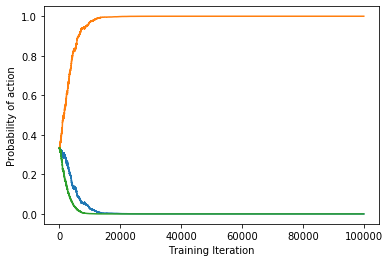

In [54]:
for i in range(1, 11):
    
    rps = RPS(0.0033, [0.40, 0.3, 0.3])
    rps.train(100_000)
    
    print(f'Experiment: {i}')
    print('Weight vector: ', rps.weights)
    print('Probabilities: ', rps.weights / np.sum(rps.weights))

# Print final run on graph
plt.plot(np.arange(1,100_001), rps.strat_lst)
plt.xlabel('Training Iteration')
plt.ylabel('Probability of action')
plt.show()

We conduct 10 experiments with `eta=0.0033` and ran for 100,000 iterations. 
In each round the opponent has a bias towards playing rock; their choice results in the reward vector generated. 

In all experiments the algorithm is able to determine that to play paper will result in minimizing regret. 
Note that here, unlike with the regret matching algorithm, we are able to determine that 'paper' should be played nearly 100% of the time, and in only approximately 10,000 iterations.